In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import plotly.graph_objects as go
url = "./data_labels_mainData.csv"
lm = pd.read_csv(url, header=0, sep=",")
url = "./data_labels_extraData.csv"
le = pd.read_csv(url, header = 0, sep = ",")

#c/download/mlass2
#im guessing all images are 27x27

"""#might have to run the following lines if wanting to use gpu
export PATH="${PATH}:/usr/local/nvidia/bin:/usr/local/cuda/bin"
CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib
export PATH="${PATH}:/usr/local/nvidia/bin:/usr/local/cuda/bin"

symbiotic links
"""
"""
cd /usr/lib/wsl/lib/
sudo cp libcuda.so.1 libcuda.so.1.backup
sudo cp libcuda.so libcuda.so.backup
sudo rm libcuda.so.1
sudo rm libcuda.so
sudo ln -s libcuda.so.1.1 libcuda.so.1
sudo ln -s libcuda.so.1.1 libcuda.so
sudo ldconfig
"""

2023-05-16 16:04:52.761659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 16:04:53.360867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'\ncd /usr/lib/wsl/lib/\nsudo cp libcuda.so.1 libcuda.so.1.backup\nsudo cp libcuda.so libcuda.so.backup\nsudo rm libcuda.so.1\nsudo rm libcuda.so\nsudo ln -s libcuda.so.1.1 libcuda.so.1\nsudo ln -s libcuda.so.1.1 libcuda.so\nsudo ldconfig\n'

In [2]:
lm.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [3]:
lm.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [4]:
lm.value_counts()

InstanceID  patientID  ImageName  cellTypeName  cellType  isCancerous
1           36         1.png      fibroblast    0         0              1
13760       54         13760.png  others        3         0              1
13753       54         13753.png  others        3         0              1
13754       54         13754.png  others        3         0              1
13755       54         13755.png  others        3         0              1
                                                                        ..
5480        50         5480.png   fibroblast    0         0              1
5481        50         5481.png   fibroblast    0         0              1
5482        50         5482.png   fibroblast    0         0              1
5483        50         5483.png   fibroblast    0         0              1
22444       27         22444.png  others        3         0              1
Length: 9896, dtype: int64

In [5]:
print(lm.groupby("cellTypeName").sum())

              InstanceID  patientID  cellType  isCancerous
cellTypeName                                              
epithelial      27445916     121296      8158         4079
fibroblast      24541213      55725         0            0
inflammatory    31935645      69164      2543            0
others          16955864      48340      4158            0


/tmp/ipykernel_19994/2613561896.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(lm.groupby("cellTypeName").sum())


In [6]:
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(lm, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(lm, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 7422, Val Data: 2474, Test Data: 1980


In [7]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.12.0'

Building the neural network requires configuring the layers of the model, then compiling the model and finally training the model.

### Set up the layers
The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most neural networks consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

A layer in the MLP is represented by `tf.keras.layers.Dense`. First lets define the dimensions of our neural network.

There are three ways to build a model in tensorflow: 
 - Functional API
 - Sub-classing
 - Sequential API

We will use the `Sequential` API to build models as it is the simplest.


### Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

- **Loss function**: This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
- **Optimizer**: This is how the model is updated based on the data it sees and its loss function.
- **Metrics**: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.


In [9]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7422 validated image filenames belonging to 4 classes.
Found 2474 validated image filenames belonging to 4 classes.


In [11]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

Now you know how to setup a neural network and train it in tensorflow.

### Incremental changes
Next step is doing the incremental updates to improve the performance. Observe the loss curves and act accordingly. Some options are.

**If the model is under fitting:** 
1. Increase the number of neurones in the hidden layer 
2. Increase the number of hidden layers

**If the model is over fitting:**
1. Add regulatization: Lasso/Ridge penalty
2. Add dropout
3. Reduce number of neurones in each layer or number of layers.

Some of the steps are done in the LectureQandA code for week 9 module - neural networks. You can get the basic syntax from there and implement accordingly.


> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Tune the neural network model to get the best performance possible. </font>**  

In [12]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


In [13]:
label_names = {'fibroplast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

In [14]:
CELL_TYPE_CLASSES = 4
CANCEROUS_CLASSES = 2

noRegModel = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

2023-05-16 16:04:55.106443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 16:04:55.129390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 16:04:55.129460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 16:04:55.132334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 16:04:55.132435: I tensorflow/compile

In [15]:
noRegModel.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [16]:
noRegModelVG1 = noRegModel.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

2023-05-16 16:04:56.404431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 16:04:57.636820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-16 16:04:58.193184: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-16 16:04:58.351439: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1ebe1090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-16 16:04:58.351495: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2023-05-16 16:04:58.356529: I tensorflow/compiler/mlir/tensorflow/utils

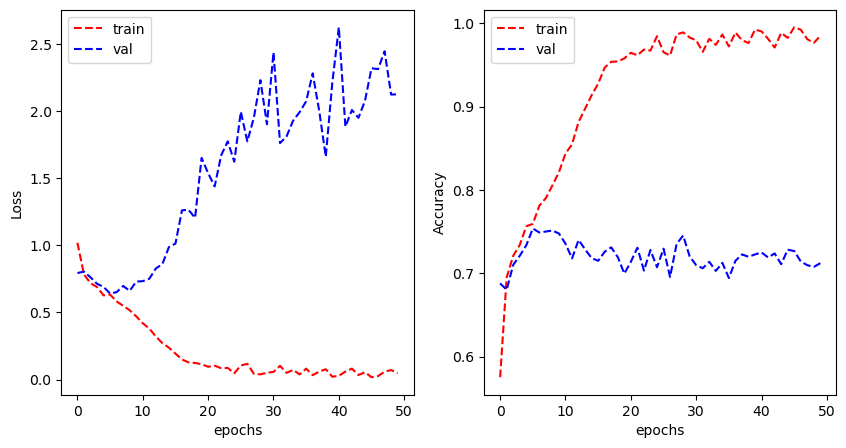

In [17]:
plot_learning_curve(noRegModelVG1.history['loss'], noRegModelVG1.history['val_loss'], 
                    noRegModelVG1.history['categorical_accuracy'], noRegModelVG1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [18]:
noRegModel.evaluate(test_generator)

2023-05-16 16:07:53.814127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 11s 6ms/step - loss: 2.2200 - categorical_accuracy: 0.7101


[2.220031499862671, 0.7101010084152222]

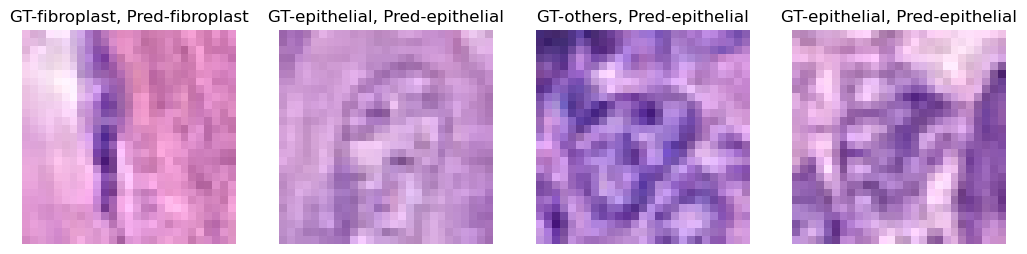

In [19]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = noRegModel.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [20]:
# Define the model architecture
reg_lambda = 0.005 #didnt make a difference, maybe try R1 regularization

cellTypeModel = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(CELL_TYPE_CLASSES, activation='softmax'),
])


In [21]:
cellTypeModel.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [22]:
cellTypeModel_VGG_1 = cellTypeModel.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/tmp/ipykernel_19994/240156875.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cellTypeModel_VGG_1 = cellTypeModel.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
2023-05-16 16:08:05.806992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 16:08:10.303553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


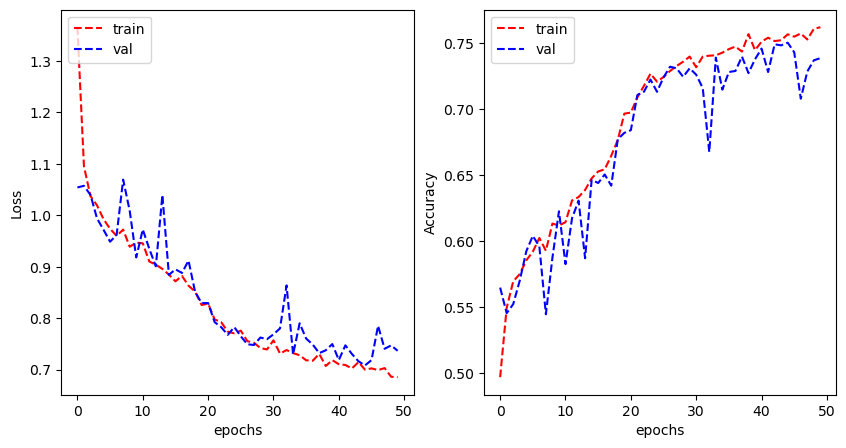

In [23]:
plot_learning_curve(cellTypeModel_VGG_1.history['loss'], cellTypeModel_VGG_1.history['val_loss'], 
                    cellTypeModel_VGG_1.history['categorical_accuracy'], cellTypeModel_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [24]:
cellTypeModel.evaluate(test_generator)

  25/1980 [..............................] - ETA: 12s - loss: 0.7284 - categorical_accuracy: 0.7600   

2023-05-16 16:11:43.811952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 13s 7ms/step - loss: 0.7373 - categorical_accuracy: 0.7394


[0.7372836470603943, 0.739393949508667]

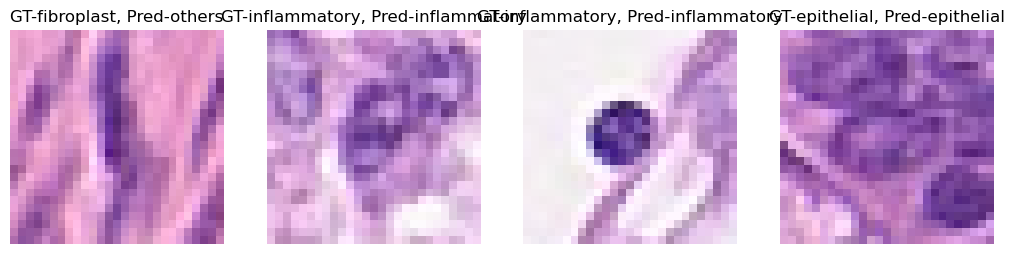

In [25]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = cellTypeModel.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

Perform image augmen/more reg techniques before doing semi supervised

In [26]:
pseudoData = ImageDataGenerator(rescale=1./255, data_format='channels_last')
pseudoGen = pseudoData.flow_from_dataframe(
        dataframe=le,
        directory='./patch_images/',
        x_col="ImageName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode=None)

Found 10384 validated image filenames.


In [27]:
predictions = cellTypeModel.predict(pseudoGen)

   40/10384 [..............................] - ETA: 27s 

2023-05-16 16:11:57.924867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10384/10384 [==============================] - 27s 3ms/step


In [28]:
# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Add the predicted labels to the second dataframe
le['cellType'] = predicted_labels

In [29]:
cellTypeModel.evaluate(test_generator)

  27/1980 [..............................] - ETA: 11s - loss: 0.6801 - categorical_accuracy: 0.7778

2023-05-16 16:12:29.726279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 13s 7ms/step - loss: 0.7373 - categorical_accuracy: 0.7394


[0.7372848987579346, 0.739393949508667]

In [30]:

train_dataHD, val_dataHD = train_test_split(le, test_size=0.2, random_state=42)


train_datagenHD = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagenHD = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27
train_dataHD['cellType'] = train_dataHD['cellType'].astype('str')
val_dataHD['cellType'] = val_dataHD['cellType'].astype('str')

train_generatorHD = train_datagenHD.flow_from_dataframe(
        dataframe=train_dataHD,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generatorHD = val_datagenHD.flow_from_dataframe(
        dataframe=val_dataHD,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 8307 validated image filenames belonging to 4 classes.
Found 2077 validated image filenames belonging to 4 classes.


Lower amount of epochs as the quality of pseudo labels are the best

In [31]:
cellTypeModel_VGG_1 = cellTypeModel.fit(train_generatorHD, validation_data = validation_generatorHD, epochs=20, verbose=0)

2023-05-16 16:12:43.088320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 16:12:46.322555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


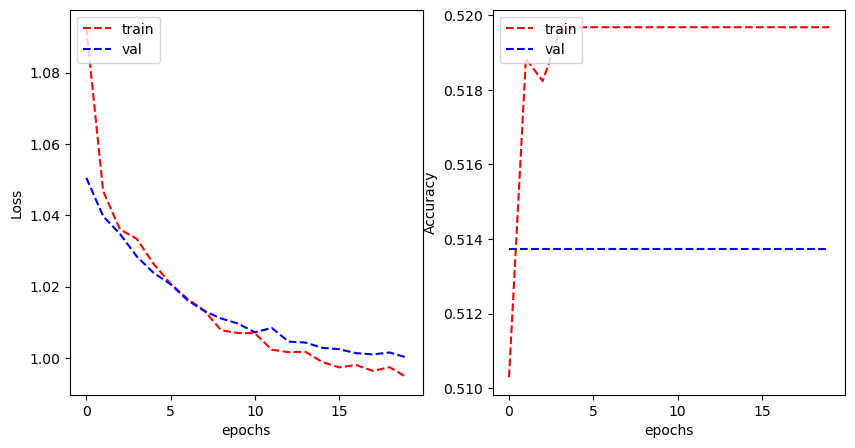

In [32]:
plot_learning_curve(cellTypeModel_VGG_1.history['loss'], cellTypeModel_VGG_1.history['val_loss'], 
                    cellTypeModel_VGG_1.history['categorical_accuracy'], cellTypeModel_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [33]:
cellTypeModel.evaluate(test_generator)

  29/1980 [..............................] - ETA: 11s - loss: 1.8142 - categorical_accuracy: 0.3793   

2023-05-16 16:13:48.486887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 12s 6ms/step - loss: 1.7162 - categorical_accuracy: 0.3995


[1.7161508798599243, 0.3994949460029602]

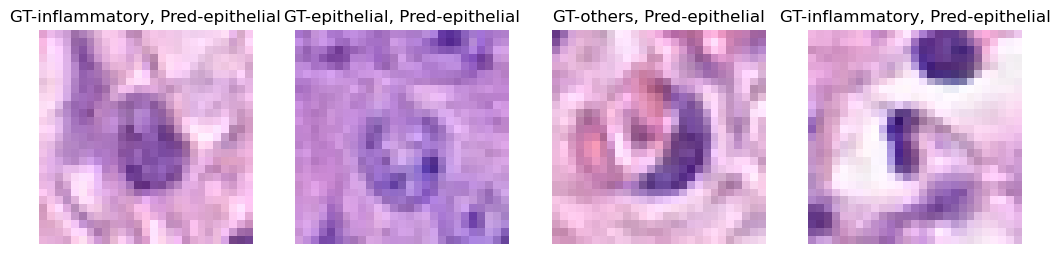

In [34]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = cellTypeModel.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

""MIGHT HAVE TO PERFORM DATA AGUMENTATION OR 
We can use any of the above techniques or a combination:
- Weight regularisation
- Dropout
- Removing layers or reducing number of kernels (making the model simple)
- Data Augmentation
- Gathering more data
- etc


PRBOS MAKE THE CANCER THING BINARY

In [35]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [36]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 7422 validated image filenames belonging to 2 classes.
Found 2474 validated image filenames belonging to 2 classes.


In [37]:
batch_x, batch_y = next(train_generator)
print(batch_x.shape)  # (batch_size, 27, 27, 3)
print(batch_y.shape)  # (batch_size, CELL_TYPE_CLASSES)


(32, 27, 27, 3)
(32,)


In [38]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 1980 validated image filenames belonging to 2 classes.


In [39]:
CANCEROUS_CLASSES = 1

# Define the model architecture
reg_lambda = 0.001

isCancerModel = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(CANCEROUS_CLASSES, activation='softmax'),
])

In [40]:
isCancerModel.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [41]:
history_VGG_1 = isCancerModel.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/tmp/ipykernel_19994/473514388.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG_1 = isCancerModel.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
2023-05-16 16:14:01.098826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 16:14:05.824870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [42]:
isCancerModel.evaluate(test_generator)

  41/1980 [..............................] - ETA: 7s - loss: 0.5442 - accuracy: 0.3171  

2023-05-16 16:16:08.439252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 8s 4ms/step - loss: 0.3211 - accuracy: 0.3995


[0.3211199641227722, 0.3994949460029602]

In [43]:
label_names = {'Not Cancer' : 0, 'Is Cancer' : 1}

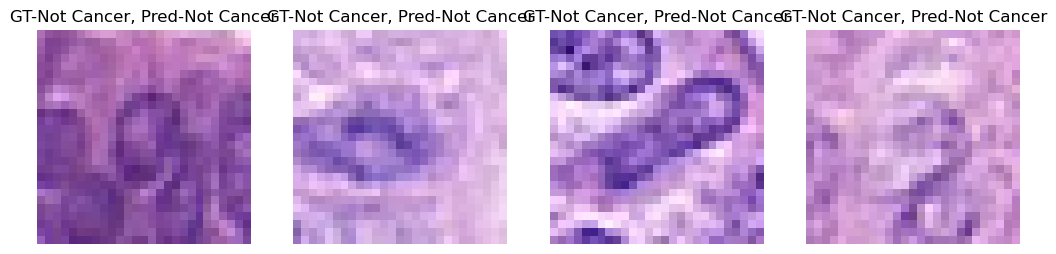

In [44]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = isCancerModel.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')